# Install AutoGluon

In [1]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Helper Functions

In [4]:
def load_csv_day_ahead_prices(year):
  region = 3

  df = pd.read_csv(f'dap-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['MTU (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['MTU (CET/CEST)', f'BZN|SE{region}', 'Currency'],
    inplace=True
  )

  return df

def day_ahead_prices(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_day_ahead_prices(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [5]:
def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [6]:
def load_csv_total_load_actual(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_actual_load(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_actual(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [7]:
# SMHI files are cut to range from 2015-2023
def load_smhi(filename):
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )

  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

## Loading in Data

In [9]:
start_year = 2015
end_year = 2019

df = day_ahead_prices(start=start_year, end_incl=end_year)
df.reset_index(inplace=True)

df['item_id'] = 0

df

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],item_id
0,2015-01-01 00:00:00,27.38,0
1,2015-01-01 01:00:00,23.37,0
2,2015-01-01 02:00:00,19.33,0
3,2015-01-01 03:00:00,17.66,0
4,2015-01-01 04:00:00,17.53,0
...,...,...,...
43819,2019-12-31 19:00:00,32.37,0
43820,2019-12-31 20:00:00,31.23,0
43821,2019-12-31 21:00:00,31.33,0
43822,2019-12-31 22:00:00,31.46,0


## Mirror Logarithm

In [10]:
def mlog(df, c=1/3):
  return np.sign(df) * (np.log(1 / c + np.abs(df)) + np.log(c))

def mlog_inv(df, c=1/3):
  return np.sign(df) * (np.exp(np.abs(df) - np.log(c)) - 1 / c)

In [11]:
df['price_log'] = mlog(df['Day-ahead Price [EUR/MWh]'])
df.drop(columns=['Day-ahead Price [EUR/MWh]'], inplace=True)
df

,MTU (CET/CEST),item_id,price_log
0,2015-01-01 00:00:00,0,2.315172
1,2015-01-01 01:00:00,0,2.173615
2,2015-01-01 02:00:00,0,2.007319
3,2015-01-01 03:00:00,0,1.929587
4,2015-01-01 04:00:00,0,1.923275
...,...,...,...
43819,2019-12-31 19:00:00,0,2.467252
43820,2019-12-31 20:00:00,0,2.434490
43821,2019-12-31 21:00:00,0,2.437407
43822,2019-12-31 22:00:00,0,2.441187


# Covariates

In [12]:
actual_load = total_actual_load(start=start_year, end_incl=end_year).reset_index()
predicted_load = total_load_forecast(start=start_year, end_incl=end_year).reset_index()

df['Actual Load'] = actual_load['Actual Total Load [MW]']
df['Predicted Load'] = predicted_load['Day-ahead Total Load Forecast [MW]']

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load
0,2015-01-01 00:00:00,0,2.315172,9560.0,8741.0
1,2015-01-01 01:00:00,0,2.173615,9520.0,8525.0
2,2015-01-01 02:00:00,0,2.007319,9277.0,8308.0
3,2015-01-01 03:00:00,0,1.929587,9132.0,8194.0
4,2015-01-01 04:00:00,0,1.923275,9083.0,8215.0
...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.467252,11080.0,10475.0
43820,2019-12-31 20:00:00,0,2.434490,10653.0,10105.0
43821,2019-12-31 21:00:00,0,2.437407,10386.0,9809.0
43822,2019-12-31 22:00:00,0,2.441187,10139.0,9603.0


In [13]:
df['month'] = df['MTU (CET/CEST)'].dt.month
df['weekday'] = df['MTU (CET/CEST)'].dt.weekday
df['hour'] = df['MTU (CET/CEST)'].dt.hour

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour
0,2015-01-01 00:00:00,0,2.315172,9560.0,8741.0,1,3,0
1,2015-01-01 01:00:00,0,2.173615,9520.0,8525.0,1,3,1
2,2015-01-01 02:00:00,0,2.007319,9277.0,8308.0,1,3,2
3,2015-01-01 03:00:00,0,1.929587,9132.0,8194.0,1,3,3
4,2015-01-01 04:00:00,0,1.923275,9083.0,8215.0,1,3,4
...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.467252,11080.0,10475.0,12,1,19
43820,2019-12-31 20:00:00,0,2.434490,10653.0,10105.0,12,1,20
43821,2019-12-31 21:00:00,0,2.437407,10386.0,9809.0,12,1,21
43822,2019-12-31 22:00:00,0,2.441187,10139.0,9603.0,12,1,22


In [14]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv').reset_index()
temperature_df = load_smhi('smhi-temperature-bma.csv').reset_index()
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1']).reset_index()

df['Solar Radiation'] = solar_df.loc[solar_df['index'] < f'{end_year + 1}-01-01']['Global Irradians']
df['Temperature'] = temperature_df.loc[temperature_df['index'] < f'{end_year + 1}-01-01']['Lufttemperatur']
df['Windspeed'] = windspeed_df.loc[windspeed_df['index'] < f'{end_year + 1}-01-01']['Vindhastighet']

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2015-01-01 00:00:00,0,2.315172,9560.0,8741.0,1,3,0,0.0,3.3,5.0
1,2015-01-01 01:00:00,0,2.173615,9520.0,8525.0,1,3,1,0.0,3.5,5.0
2,2015-01-01 02:00:00,0,2.007319,9277.0,8308.0,1,3,2,0.0,2.9,3.0
3,2015-01-01 03:00:00,0,1.929587,9132.0,8194.0,1,3,3,0.0,2.8,5.0
4,2015-01-01 04:00:00,0,1.923275,9083.0,8215.0,1,3,4,0.0,2.7,5.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.467252,11080.0,10475.0,12,1,19,0.0,2.5,5.0
43820,2019-12-31 20:00:00,0,2.434490,10653.0,10105.0,12,1,20,0.0,2.2,3.0
43821,2019-12-31 21:00:00,0,2.437407,10386.0,9809.0,12,1,21,0.0,2.1,3.0
43822,2019-12-31 22:00:00,0,2.441187,10139.0,9603.0,12,1,22,0.0,2.2,4.0


## Scaling down

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['price_log']] = scaler.fit_transform(df[['price_log']])
df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']] = MinMaxScaler().fit_transform(df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']])

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2015-01-01 00:00:00,0,0.515480,0.348817,0.293004,1,3,0,0.0,0.449020,0.416667
1,2015-01-01 01:00:00,0,0.483419,0.345608,0.274417,1,3,1,0.0,0.452941,0.416667
2,2015-01-01 02:00:00,0,0.445755,0.326113,0.255744,1,3,2,0.0,0.441176,0.250000
3,2015-01-01 03:00:00,0,0.428149,0.314481,0.245934,1,3,3,0.0,0.439216,0.416667
4,2015-01-01 04:00:00,0,0.426720,0.310550,0.247741,1,3,4,0.0,0.437255,0.416667
...,...,...,...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,0.549925,0.470758,0.442217,12,1,19,0.0,0.433333,0.416667
43820,2019-12-31 20:00:00,0,0.542505,0.436502,0.410378,12,1,20,0.0,0.427451,0.250000
43821,2019-12-31 21:00:00,0,0.543166,0.415082,0.384907,12,1,21,0.0,0.425490,0.250000
43822,2019-12-31 22:00:00,0,0.544022,0.395267,0.367180,12,1,22,0.0,0.427451,0.333333


# Create the AutoGluon Timeseries

In [16]:
series = TimeSeriesDataFrame.from_data_frame(
  df,
  id_column='item_id',
  timestamp_column='MTU (CET/CEST)'
)

series['month'] = series['month'].astype('category')
series['weekday'] = series['weekday'].astype('category')
series['hour'] = series['hour'].astype('category')

series.head()

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2015-01-01 00:00:00   0.515480     0.348817        0.293004     1   
        2015-01-01 01:00:00   0.483419     0.345608        0.274417     1   
        2015-01-01 02:00:00   0.445755     0.326113        0.255744     1   
        2015-01-01 03:00:00   0.428149     0.314481        0.245934     1   
        2015-01-01 04:00:00   0.426720     0.310550        0.247741     1   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2015-01-01 00:00:00       3    0              0.0     0.449020   
        2015-01-01 01:00:00       3    1              0.0     0.452941   
        2015-01-01 02:00:00       3    2              0.0     0.441176   
        2015-01-01 03:00:00       3    3              0.0     0.439216   
        2015-01-01 04:00:00       3    4              0.0     0.437255   

                             Windspeed  
item_id timestamp                       
0       2015-01-01 00:00:00   0.416667  
        2015-01-01 01:00:00   0.416667  
        2015-01-01 02:00:00   0.250000  
        2015-01-01 03:00:00   0.416667  
        2015-01-01 04:00:00   0.416667

In [17]:
cutoff = pd.Timestamp(f'{end_year}-01-01')
train, test = series.split_by_time(cutoff)

train

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2015-01-01 00:00:00   0.515480     0.348817        0.293004     1   
        2015-01-01 01:00:00   0.483419     0.345608        0.274417     1   
        2015-01-01 02:00:00   0.445755     0.326113        0.255744     1   
        2015-01-01 03:00:00   0.428149     0.314481        0.245934     1   
        2015-01-01 04:00:00   0.426720     0.310550        0.247741     1   
...                                ...          ...             ...   ...   
        2018-12-31 19:00:00   0.630625     0.465945        0.478272    12   
        2018-12-31 20:00:00   0.622917     0.421580        0.435677    12   
        2018-12-31 21:00:00   0.609589     0.389491        0.394458    12   
        2018-12-31 22:00:00   0.586343     0.362615        0.365545    12   
        2018-12-31 23:00:00   0.502596     0.342880        0.338439    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2015-01-01 00:00:00       3    0              0.0     0.449020   
        2015-01-01 01:00:00       3    1              0.0     0.452941   
        2015-01-01 02:00:00       3    2              0.0     0.441176   
        2015-01-01 03:00:00       3    3              0.0     0.439216   
        2015-01-01 04:00:00       3    4              0.0     0.437255   
...                             ...  ...              ...          ...   
        2018-12-31 19:00:00       0   19              0.0     0.419608   
        2018-12-31 20:00:00       0   20              0.0     0.429412   
        2018-12-31 21:00:00       0   21              0.0     0.441176   
        2018-12-31 22:00:00       0   22              0.0     0.452941   
        2018-12-31 23:00:00       0   23              0.0     0.462745   

                             Windspeed  
item_id timestamp                       
0       2015-01-01 00:00:00   0.416667  
        2015-01-01 01:00:00   0.416667  
        2015-01-01 02:00:00   0.250000  
        2015-01-01 03:00:00   0.416667  
        2015-01-01 04:00:00   0.416667  
...                                ...  
        2018-12-31 19:00:00   0.416667  
        2018-12-31 20:00:00   0.416667  
        2018-12-31 21:00:00   0.333333  
        2018-12-31 22:00:00   0.250000  
        2018-12-31 23:00:00   0.333333  

[35064 rows x 9 columns]

In [18]:
test

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2019-01-01 00:00:00   0.522382     0.320899        0.329662     1   
        2019-01-01 01:00:00   0.324444     0.308464        0.312538     1   
        2019-01-01 02:00:00   0.323750     0.299799        0.294553     1   
        2019-01-01 03:00:00   0.200452     0.288809        0.283883     1   
        2019-01-01 04:00:00   0.208400     0.288167        0.276482     1   
...                                ...          ...             ...   ...   
        2019-12-31 19:00:00   0.549925     0.470758        0.442217    12   
        2019-12-31 20:00:00   0.542505     0.436502        0.410378    12   
        2019-12-31 21:00:00   0.543166     0.415082        0.384907    12   
        2019-12-31 22:00:00   0.544022     0.395267        0.367180    12   
        2019-12-31 23:00:00   0.539843     0.361091        0.347474    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.466667   
        2019-01-01 01:00:00       1    1              0.0     0.494118   
        2019-01-01 02:00:00       1    2              0.0     0.505882   
        2019-01-01 03:00:00       1    3              0.0     0.513725   
        2019-01-01 04:00:00       1    4              0.0     0.498039   
...                             ...  ...              ...          ...   
        2019-12-31 19:00:00       1   19              0.0     0.433333   
        2019-12-31 20:00:00       1   20              0.0     0.427451   
        2019-12-31 21:00:00       1   21              0.0     0.425490   
        2019-12-31 22:00:00       1   22              0.0     0.427451   
        2019-12-31 23:00:00       1   23              0.0     0.427451   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000  
...                                ...  
        2019-12-31 19:00:00   0.416667  
        2019-12-31 20:00:00   0.250000  
        2019-12-31 21:00:00   0.250000  
        2019-12-31 22:00:00   0.333333  
        2019-12-31 23:00:00   0.250000  

[8760 rows x 9 columns]

# Model Creation

In [19]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    freq="H",
    path="autogluon-day-ahead",
    target="price_log",
    eval_metric="MSE",
)

predictor.fit(
    train,
    num_val_windows=52,
    refit_every_n_windows=None,
    val_step_size=168,
    presets="high_quality",
    time_limit=1500,
)

Beginning AutoGluon training... Time limit = 1500s
AutoGluon will save models to 'autogluon-day-ahead'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       11.46 GB / 12.67 GB (90.4%)
Disk Space Avail:   75.26 GB / 107.72 GB (69.9%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 52,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'price_log',
 'time_limit': 1500,
 'val_step_size': 168,
 'verbosity': 2}

Provided train_data has 35064 rows, 1 time series. Median time ser

# Prediction Time

In [20]:
history = series.slice_by_time(pd.Timestamp(f'{end_year - 1}-12-30'), pd.Timestamp(f'{end_year}-01-01'))
prediction = predictor.predict(history, model='WeightedEnsemble')
prediction

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.606051  0.568010  0.585785  0.592767  0.599896   
        2019-01-01 01:00:00  0.607874  0.571597  0.588042  0.593802  0.602056   
        2019-01-01 02:00:00  0.614426  0.575914  0.593394  0.599669  0.609445   
        2019-01-01 03:00:00  0.622094  0.585156  0.601042  0.607383  0.616785   
        2019-01-01 04:00:00  0.630720  0.593945  0.609141  0.617363  0.625284   
        2019-01-01 05:00:00  0.642306  0.606823  0.620133  0.629143  0.635992   
        2019-01-01 06:00:00  0.650175  0.621679  0.634051  0.640778  0.646732   
        2019-01-01 07:00:00  0.653093  0.623750  0.636038  0.643026  0.648344   
        2019-01-01 08:00:00  0.657306  0.629965  0.640500  0.646680  0.651203   
        2019-01-01 09:00:00  0.657001  0.629220  0.640310  0.647701  0.652571   
        2019-01-01 10:00:00  0.656192  0.630974  0.641029  0.647304  0.651232   
        2019-01-01 11:00:00  0.655265  0.631199  0.640913  0.646989  0.650548   
        2019-01-01 12:00:00  0.653619  0.630217  0.640283  0.646574  0.650053   
        2019-01-01 13:00:00  0.653105  0.627485  0.638217  0.645218  0.649491   
        2019-01-01 14:00:00  0.651775  0.629320  0.639554  0.645391  0.649083   
        2019-01-01 15:00:00  0.653849  0.631895  0.640667  0.645908  0.650125   
        2019-01-01 16:00:00  0.655053  0.630598  0.639941  0.645788  0.649753   
        2019-01-01 17:00:00  0.654084  0.631024  0.640634  0.645333  0.649515   
        2019-01-01 18:00:00  0.652703  0.627229  0.637694  0.643960  0.648811   
        2019-01-01 19:00:00  0.650560  0.627366  0.637001  0.642637  0.646577   
        2019-01-01 20:00:00  0.648827  0.623408  0.634467  0.639519  0.644062   
        2019-01-01 21:00:00  0.645845  0.621082  0.630106  0.636048  0.640559   
        2019-01-01 22:00:00  0.640600  0.616563  0.626227  0.632363  0.636321   
        2019-01-01 23:00:00  0.637402  0.612791  0.623713  0.629153  0.633303   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
0       2019-01-01 00:00:00  0.605440  0.608986  0.613451  0.616555  0.623106  
        2019-01-01 01:00:00  0.607581  0.611123  0.616274  0.619099  0.625328  
        2019-01-01 02:00:00  0.614407  0.618061  0.622975  0.626341  0.632907  
        2019-01-01 03:00:00  0.621768  0.625671  0.630629  0.633153  0.640469  
        2019-01-01 04:00:00  0.630361  0.633724  0.638959  0.642556  0.649949  
        2019-01-01 05:00:00  0.640597  0.644238  0.648394  0.654587  0.662153  
        2019-01-01 06:00:00  0.650284  0.653629  0.658756  0.665730  0.672305  
        2019-01-01 07:00:00  0.653184  0.656610  0.662038  0.672085  0.679831  
        2019-01-01 08:00:00  0.656254  0.659896  0.665079  0.674639  0.684145  
        2019-01-01 09:00:00  0.656790  0.660784  0.665588  0.672897  0.681592  
        2019-01-01 10:00:00  0.655642  0.660890  0.665024  0.670929  0.681059  
        2019-01-01 11:00:00  0.655076  0.658622  0.663771  0.669859  0.680500  
        2019-01-01 12:00:00  0.654027  0.658495  0.662897  0.666887  0.675633  
        2019-01-01 13:00:00  0.653250  0.657526  0.661602  0.665606  0.676422  
        2019-01-01 14:00:00  0.652616  0.656876  0.660729  0.665121  0.675334  
        2019-01-01 15:00:00  0.654053  0.658263  0.662144  0.666247  0.676789  
        2019-01-01 16:00:00  0.653460  0.657952  0.661993  0.667142  0.679675  
        2019-01-01 17:00:00  0.653280  0.657276  0.661099  0.666758  0.676992  
        2019-01-01 18:00:00  0.652913  0.656196  0.660513  0.666743  0.675186  
        2019-01-01 19:00:00  0.650903  0.653731  0.657761  0.662856  0.669531  
        2019-01-01 20:00:00  0.648996  0.651770  0.655707  0.660918  0.667558  
        2019-01-01 21:00:00  0.645291  0.648534  0.653029  0.658651  0.665098  
      

## Predicting the Test Set

In [21]:
forecasts = []

for day in pd.date_range(f'{end_year}-01-01', f'{end_year}-12-31'):
  print(f'Forecasting day {day.strftime("%Y-%m-%d")}')
  history = series.slice_by_time(day - pd.DateOffset(days=2), day)
  forecast = predictor.predict(history, model='WeightedEnsemble')
  forecasts.append(forecast)

forecasts = pd.concat(forecasts)

Forecasting day 2019-01-01
Forecasting day 2019-01-02
Forecasting day 2019-01-03
Forecasting day 2019-01-04
Forecasting day 2019-01-05
Forecasting day 2019-01-06
Forecasting day 2019-01-07
Forecasting day 2019-01-08
Forecasting day 2019-01-09
Forecasting day 2019-01-10
Forecasting day 2019-01-11
Forecasting day 2019-01-12
Forecasting day 2019-01-13
Forecasting day 2019-01-14
Forecasting day 2019-01-15
Forecasting day 2019-01-16
Forecasting day 2019-01-17
Forecasting day 2019-01-18
Forecasting day 2019-01-19
Forecasting day 2019-01-20
Forecasting day 2019-01-21
Forecasting day 2019-01-22
Forecasting day 2019-01-23
Forecasting day 2019-01-24
Forecasting day 2019-01-25
Forecasting day 2019-01-26
Forecasting day 2019-01-27
Forecasting day 2019-01-28
Forecasting day 2019-01-29
Forecasting day 2019-01-30
Forecasting day 2019-01-31
Forecasting day 2019-02-01
Forecasting day 2019-02-02
Forecasting day 2019-02-03
Forecasting day 2019-02-04
Forecasting day 2019-02-05
Forecasting day 2019-02-06
F

Looks promising!

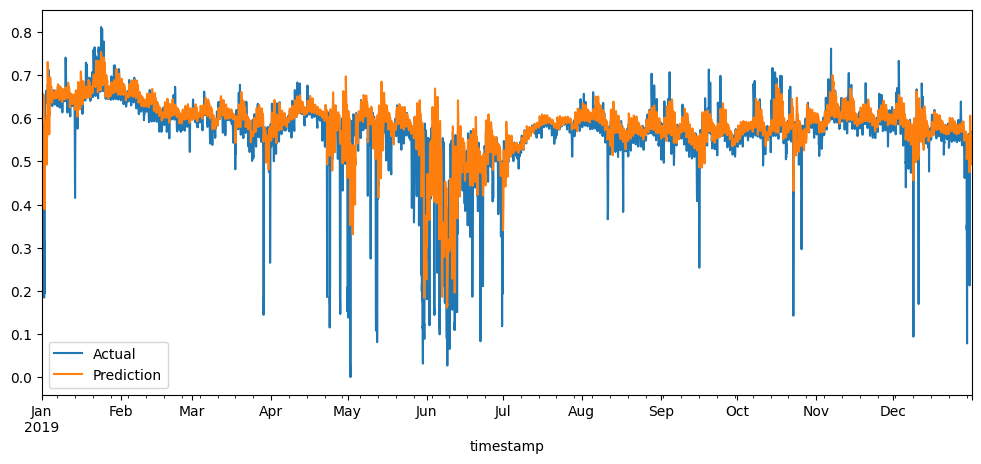

In [22]:
plt.figure(figsize=(12, 5))
test.loc[0]['price_log'].plot(label='Actual')
forecasts.loc[0]['mean'].plot(label='Prediction')
plt.legend()

## Zooming in on a Month

(430944.0, 431688.0)

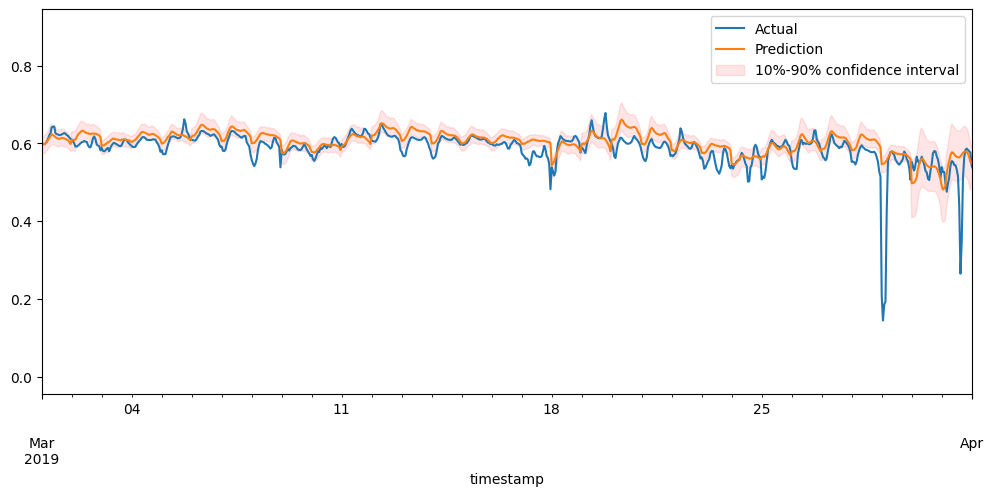

In [23]:
plt.figure(figsize=(12, 5))

y_pred = forecasts.loc[0]
y_test = test.loc[0]

y_test['price_log'].plot(label='Actual')
y_pred['mean'].plot(label='Prediction')

plt.fill_between(
  y_pred.index,
  y_pred["0.1"],
  y_pred["0.9"],
  color="red",
  alpha=0.1,
  label=f"10%-90% confidence interval"
)
plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Scaling Back

In [24]:
forecasts['Forecasted Price'] = mlog_inv(scaler.inverse_transform(forecasts['mean'].values.reshape(-1, 1)))
forecasts

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.606051  0.568010  0.585785  0.592767  0.599896   
        2019-01-01 01:00:00  0.607874  0.571597  0.588042  0.593802  0.602056   
        2019-01-01 02:00:00  0.614426  0.575914  0.593394  0.599669  0.609445   
        2019-01-01 03:00:00  0.622094  0.585156  0.601042  0.607383  0.616785   
        2019-01-01 04:00:00  0.630720  0.593945  0.609141  0.617363  0.625284   
...                               ...       ...       ...       ...       ...   
        2019-12-31 19:00:00  0.547569  0.493301  0.512952  0.527098  0.537183   
        2019-12-31 20:00:00  0.534620  0.475965  0.499379  0.514184  0.523762   
        2019-12-31 21:00:00  0.520331  0.459805  0.486287  0.499176  0.509141   
        2019-12-31 22:00:00  0.506636  0.444017  0.471235  0.484357  0.494554   
        2019-12-31 23:00:00  0.493297  0.429694  0.458072  0.471399  0.482381   

                                  0.5       0.6       0.7       0.8       0.9  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.605440  0.608986  0.613451  0.616555  0.623106   
        2019-01-01 01:00:00  0.607581  0.611123  0.616274  0.619099  0.625328   
        2019-01-01 02:00:00  0.614407  0.618061  0.622975  0.626341  0.632907   
        2019-01-01 03:00:00  0.621768  0.625671  0.630629  0.633153  0.640469   
        2019-01-01 04:00:00  0.630361  0.633724  0.638959  0.642556  0.649949   
...                               ...       ...       ...       ...       ...   
        2019-12-31 19:00:00  0.547539  0.556705  0.568718  0.592146  0.617927   
        2019-12-31 20:00:00  0.534887  0.543308  0.554593  0.574792  0.596117   
        2019-12-31 21:00:00  0.520444  0.529021  0.539624  0.556471  0.574883   
        2019-12-31 22:00:00  0.506010  0.514969  0.525367  0.539139  0.556824   
        2019-12-31 23:00:00  0.493525  0.502815  0.513160  0.524882  0.540744   

                             Forecasted Price  
item_id timestamp                              
0       2019-01-01 00:00:00         42.316539  
        2019-01-01 01:00:00         42.682651  
        2019-01-01 02:00:00         44.023593  
        2019-01-01 03:00:00         45.642769  
        2019-01-01 04:00:00         47.531218  
...                                       ...  
        2019-12-31 19:00:00         32.004061  
        2019-12-31 20:00:00         30.058799  
        2019-12-31 21:00:00         28.037602  
        2019-12-31 22:00:00         26.216558  
        2019-12-31 23:00:00         24.545564  

[8760 rows x 11 columns]

# Predictions vs Actual Dataset

(430944.0, 431688.0)

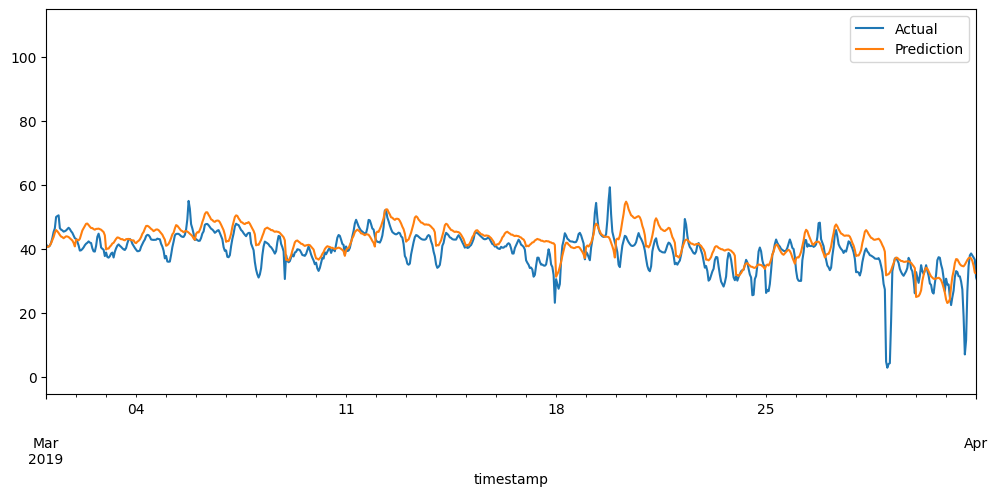

In [25]:
plt.figure(figsize=(12, 5))

actual_prices = day_ahead_prices(start=end_year, end_incl=end_year)
y_pred = forecasts.loc[0]

actual_prices['Day-ahead Price [EUR/MWh]'].plot(label='Actual')
y_pred['Forecasted Price'].plot(label='Prediction')

plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Evaluation
For simplicity's sake, let's use Darts to evaluate the performance, just to be consistent with other models.

In [26]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=363839a1135f4a58e6b95326b478a06557aafcc5b9d2925a2c5dfd9775a5e2cb
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [27]:
from darts.metrics.metrics import _get_values_or_raise

def wape(actual_series, pred_series):
  y_true, y_hat = _get_values_or_raise(actual_series, pred_series, intersect=True, remove_nan_union=True)
  return 100.0 * np.sum(np.abs(y_true - y_hat)) / np.sum(np.abs(y_true))

In [29]:
from darts import TimeSeries
from darts.metrics import mape, rmse

actual_ts = TimeSeries.from_dataframe(actual_prices)
prediction_ts = TimeSeries.from_series(forecasts.loc[0]['Forecasted Price'])

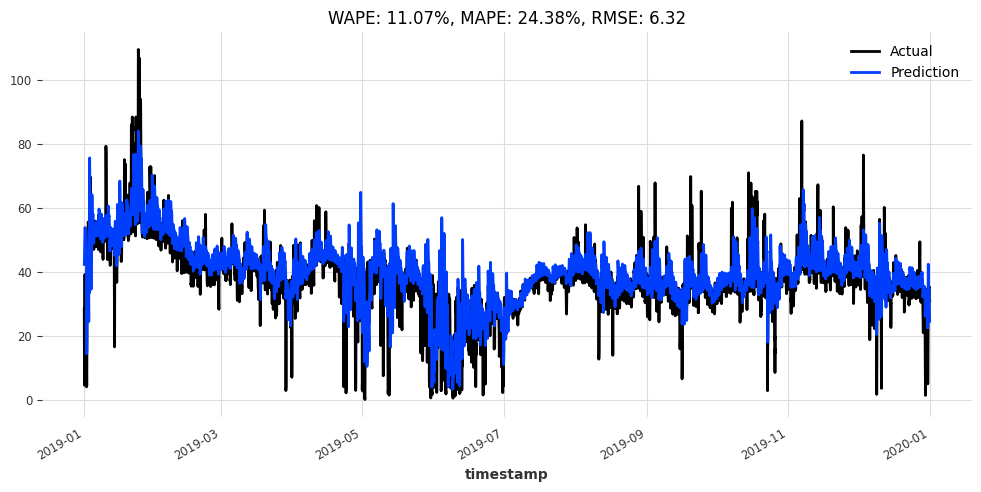

In [32]:
plt.figure(figsize=(12, 5))
actual_ts.plot(label='Actual')
prediction_ts.plot(label='Prediction')

plt.title('WAPE: {:.2f}%, MAPE: {:.2f}%, RMSE: {:.2f}'.format(wape(actual_ts, prediction_ts), mape(actual_ts, prediction_ts), rmse(actual_ts, prediction_ts)))
plt.legend()